#Task 2 -Speaker classificaion

Feature extraction on audio signal using a pre-trained Wav2Vec2 model

#data preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!tar -xvf /content/drive/MyDrive/voiseed/dev-clean.tar.gz 

In [8]:
!ls /content/LibriSpeech

BOOKS.TXT  CHAPTERS.TXT  dev-clean  LICENSE.TXT  README.TXT  SPEAKERS.TXT


In [9]:
import pandas as pd
df=pd.read_fwf('/content/LibriSpeech/SPEAKERS.TXT',delimiter='|',skiprows=12, names=['id', 'sex', 'subset', 'minutes', 'name'])


In [10]:
df['sex'] = df['sex'].str.strip()
df['subset'] = df['subset'].str.strip()
df['name'] = df['name'].str.strip()

dev-clean has 20 male and 20 Female

In [ ]:
df.value_counts(["sex", "subset"])

Take only the dev-clean subset

In [12]:
newdf = df.loc[df['subset'] == "dev-clean"].reset_index(drop=True)

In [13]:
df = newdf

In [ ]:
!pip install transformers

In [ ]:
import torch
import torchaudio
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Processor



model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

In [5]:
import pandas as pd
features_df = pd.DataFrame()

In [15]:
import os
import glob
from fnmatch import fnmatch
root = "/content/LibriSpeech/dev-clean/"

ind = pd.DataFrame(columns=['id', 'filename'])
df2 = pd.DataFrame(columns=['id', 'features'])
ids = df["id"].values.tolist()
fi = []

for id in ids:
    s = str(id)
    pattern = os.path.join(root, f'{s}/*/*.flac')
    files = glob.glob(pattern)
    for file in files:
        fi.append(file)

ind["filename"] = fi
name = [(s.split("/")[-1]) for s in fi]
slist = [(s.split("-")[0]) for s in name]
ind["id"] = [int(s) for s in slist]


This function splits the audio files into 2 seconds chunks

In [16]:
def extract_chunks(waveform, sample_rate=16000):
    chunk_samples = sample_rate * 2 
    chunks = []
    for i in range(0, len(waveform), chunk_samples):
        chunk = waveform[i:i+chunk_samples]
        if len(chunk) == chunk_samples: 
            chunks.append(chunk)
    return chunks

Here we take each audio file, pass it to extract_chunks to split it into 2 seconds chunks, and then we extract features from all these chunks and store then to as feature_list. We finally get feature array of shape (8392, 99, 768). ie, we have a 768 features taken from 99 frames of 8392 audios. 

In [ ]:
import librosa
features_list = []
sample_rate = 16000
id_list = []
for index, row in ind.iterrows():
    print(index)
    audio_file = row['filename']
    waveform, sample_rate = librosa.load(audio_file,  sr=16000, mono=False)  

    chunks = extract_chunks(waveform) 
    fixed_length = 2
    for chunk in chunks:
      if len(chunk) > fixed_length * sample_rate:
        chunk = chunk[:fixed_length * sample_rate]
      else:
        chunk = np.pad(chunk, (0, fixed_length * sample_rate - len(chunk)), mode='constant')
      id_list.append(row['id'])
      with torch.no_grad():
          inputs = feature_extractor(chunk, sampling_rate=16000, return_tensors="pt", padding=True)
          features = model(inputs.input_values).last_hidden_state

          features_list.append(features.numpy())
features_array = np.concatenate(features_list, axis=0)

In [17]:
print(features_array.shape)

(8392, 99, 768)


Now we take the mean across all frames and get 768 features for each audio. We can also do reshape to get 99*768 features. But it will be too many features to train, so I took the mean instead. 

In [18]:
f = [np.mean(i, axis=1).squeeze() for i in features_list]

sp = pd.DataFrame()
sp['id'] = id_list
sp['features']= f

As it takes a long time to extract features from all the audio, let us store the final dataframe so we don't have to rerun the feature extraction again.

In [20]:
import pickle

# store dataframe in file using pickle.dump
with open('/content/drive/MyDrive/voiseed/sp.pkl', 'wb') as file:
    pickle.dump(sp, file)

In [19]:
import pickle
with open('/content/drive/MyDrive/voiseed/sp.pkl', 'rb') as file:
    sp = pickle.load(file)

In [112]:
X = np.array(sp.features.tolist())
y = np.array(sp.id.tolist())

In [37]:
np.unique(y, return_counts=True)

(array([  84,  174,  251,  422,  652,  777, 1272, 1462, 1673, 1919, 1988,
        1993, 2035, 2078, 2086, 2277, 2412, 2428, 2803, 2902, 3000, 3081,
        3170, 3536, 3576, 3752, 3853, 5338, 5536, 5694, 5895, 6241, 6295,
        6313, 6319, 6345, 7850, 7976, 8297, 8842]),
 array([211, 218, 201, 234, 210, 203, 204, 203, 221, 212, 209, 213, 204,
        217, 213, 193, 212, 198, 219, 225, 220, 191, 216, 213, 221, 197,
        212, 211, 217, 199, 203, 206, 207, 198, 215, 208, 210, 208, 205,
        215]))

To split the data to train and test set, we have to make sure test set do not have any ids that are not present in the train set. Also as some ids have very few data points, we oversample it.

In [38]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# create oversampler object
oversample = RandomOverSampler()

# oversample the dataset
X_resampled, y_resampled = oversample.fit_resample(X, y)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)


#Quantitative analysis

Now we train different classifiers using this dataset

##SVM

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
clf = SVC(kernel='linear', C=1, decision_function_shape='ovr')
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.98868374032162
Precision: 0.9890101614238095
Recall: 0.98868374032162


##Naive Bayes

In [40]:
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
nb = naive_bayes.GaussianNB();
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.7659321024419298
Precision: 0.7917962553174565
Recall: 0.7659321024419298


##Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_classifier = LogisticRegression(max_iter=500)
lr_classifier.fit(X_train_scaled, y_train)
y_pred_lr = lr_classifier.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))


Accuracy: 0.7659321024419298
Precision: 0.7917962553174565
Recall: 0.7659321024419298


##Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the model on training data
rf_classifier.fit(X_train, y_train)

# Make predictions on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.8558665872543181


##XGBoost

For training XGBoost we need the labels to be encoded from 0 to (number of classes - 1). We do that using label encoder

In [171]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit encoder on y_train and transform y_train and y_test
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# define model parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train_enc)),
    'max_depth': 3,
    'eval_metric': 'merror'
}

# convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_enc)
dtest = xgb.DMatrix(X_test)

# train the model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# make predictions on test set
y_pred = xgb_model.predict(dtest)

# calculate accuracy
accuracy = accuracy_score(y_test_enc, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9358974358974359


##FFNN

Inorder to train a neural network for multiclass classification we either need to use one-hot encoding. But as our labels are integers we can use "sparse_categorical_crossentropy" as loss function and avoid one-hot encoding

In [174]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics 
from sklearn.preprocessing import OneHotEncoder

"""onehot_encoder = OneHotEncoder()
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(-1, 1))"""

model = Sequential()

model.add(Dense(64, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(40))
model.add(Activation('softmax'))


model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)


checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001, verbose=1)


history = model.fit(X_train, y_train_enc, batch_size=32, epochs=150, validation_data=(X_test, y_test_enc),
                    callbacks=[early_stop, checkpoint, reduce_lr])


model.load_weights('best_model_weights.h5')


loss, accuracy = model.evaluate(X_test, y_test_enc)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/150
203/210 [============================>.] - ETA: 0s - loss: 3.4679 - accuracy: 0.1187
Epoch 1: val_accuracy improved from -inf to 0.30018, saving model to best_model_weights.h5
210/210 [==============================] - 3s 9ms/step - loss: 3.4584 - accuracy: 0.1214 - val_loss: 3.0652 - val_accuracy: 0.3002 - lr: 0.0010
Epoch 2/150
207/210 [============================>.] - ETA: 0s - loss: 2.7714 - accuracy: 0.3099
Epoch 2: val_accuracy improved from 0.30018 to 0.55688, saving model to best_model_weights.h5
210/210 [==============================] - 1s 6ms/step - loss: 2.7667 - accuracy: 0.3104 - val_loss: 2.3108 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 3/150
204/210 [============================>.] - ETA: 0s - loss: 2.1845 - accuracy: 0.4491
Epoch 3: val_accuracy improved from 0.55688 to 0.71888, saving model to best_model_weights.h5
210/210 [==============================] - 1s 7ms/step - loss: 2.1771 - accuracy: 0.4509 - val_loss: 1.7425 - val_accuracy: 0.7189 - lr: 0.001

##CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics 

# Define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001, verbose=1)

# Train model
history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_enc, 
                    batch_size=32, epochs=150, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_enc),
                    callbacks=[early_stop, checkpoint, reduce_lr])

# Evaluate model
loss, accuracy = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_enc)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/150
234/234 [==============================] - ETA: 0s - loss: 2.1321 - accuracy: 0.4832
Epoch 1: val_accuracy improved from -inf to 0.81410, saving model to best_model_weights.h5
234/234 [==============================] - 16s 14ms/step - loss: 2.1321 - accuracy: 0.4832 - val_loss: 0.8103 - val_accuracy: 0.8141 - lr: 0.0010
Epoch 2/150
220/234 [===========================>..] - ETA: 0s - loss: 0.5835 - accuracy: 0.8469
Epoch 2: val_accuracy improved from 0.81410 to 0.90972, saving model to best_model_weights.h5
234/234 [==============================] - 2s 7ms/step - loss: 0.5693 - accuracy: 0.8507 - val_loss: 0.3813 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 3/150
230/234 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.9170
Epoch 3: val_accuracy did not improve from 0.90972
234/234 [==============================] - 1s 5ms/step - loss: 0.3053 - accuracy: 0.9164 - val_loss: 0.3580 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 4/150
228/234 [==================

Here are the final model reults:

SVM: 0.989

Naive Bayes: 0.766

Logistic Regression: 0.766

Random Forest: 0.856

XGBoost:0.936

FFNN: 0.989

CNN: 0.990

The CNN and FFNN models are performing the best with accuracy scores of 0.99 and 0.989 respectively. SVM and XGBoost also have high accuracy scores of 0.989 and 0.936, respectively. Naive Bayes and Logistic Regression, however, seem to be performing relatively poorly with accuracy scores of 0.766. 

SVM with a linear kernel is particularly effective in high-dimensional spaces, such as datasets with many features. It works by finding a hyperplane that separates the classes in the data, and when the number of features is high, the chances of finding a good hyperplane increase. 

SVM gave very good result, even close to Neural network result.

 Logistic Regression, on the other hand, assumes a linear relationship between the features and the target variable, which may not be sufficient to capture the complexity of the data.

We can use non-linear transformations on the input features, or use kernel tricks to make LR work capture non-linearity

 RF suffer from the curse of dimensionality, which means that as the number of features increases, the sparsity of the data increases, and it becomes more difficult to find meaningful patterns. The performance of Random Forest may also depend on the specific parameters used in the model, such as the number of trees and the depth of the trees. With right hyper parameters the accuracy can be improved

XGBoost has built-in regularization techniques that help to prevent overfitting and improve generalization. This can be especially useful in situations where there are many features as in our case to avoid overfitting. This might be why it gave good results.

FFNNs and CNNs are neural network models that can handle non-linear relationships among features and are generally more powerful than traditional machine learning algorithms like SVM, LR, and RF. 

CNNs are specifically designed for image and signal processing tasks where the input data has a spatial structure, such as images or audio signals. 

So even with a very simple model FFNN and CNN both gave best results

#Qualitative analysis

Maximum proportion of variance explained is 0.2, it means that the first principal component only explains 20% of the variance in the data. This could be due to several reasons, such as having noisy or irrelevant features, or having a high degree of multicollinearity between the features. Observing the elbow,We can take as number of components 2 or 3. Also it is easy to visualize.

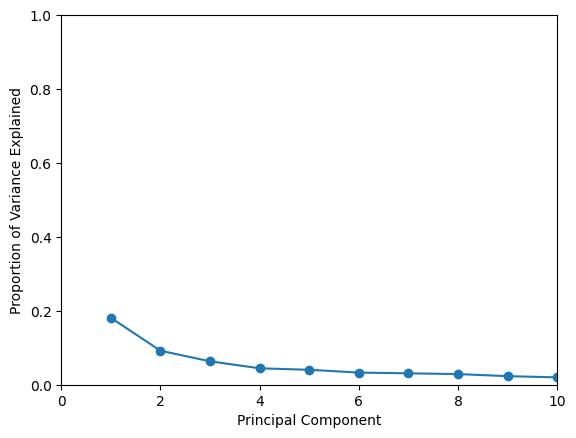

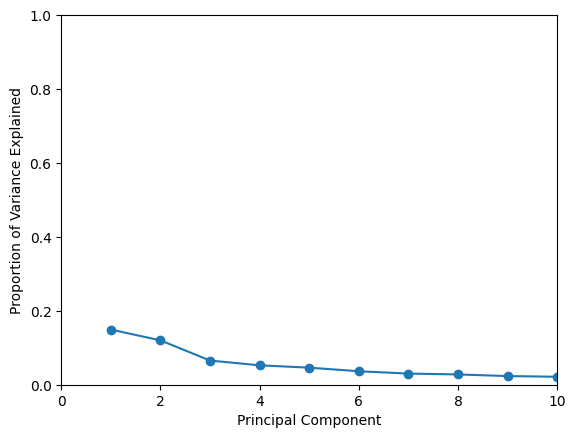

In [115]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA model to data
pca = PCA()
pca.fit(X)

# Plot scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.ylabel('Proportion of Variance Explained')
plt.show()

"""
#select only 10 ids for easier visualization than complete 40 labels.
pca = PCA()
pca.fit(X_selected)

# Plot scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.ylabel('Proportion of Variance Explained')
plt.show()"""

We use PCA, umap and LDA for dimentionality reduction and we do k-means clustering on all 3 reduced and also on the original data

In [ ]:
!pip install umap-learn

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap

In [159]:
pca_model = PCA(n_components=2)
pca_result = pca_model.fit_transform(X)

In [ ]:
# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(X)

In [153]:
# Perform LDA dimensionality reduction
lda_model = LDA(n_components=2)
lda_result = lda_model.fit_transform(X,y)


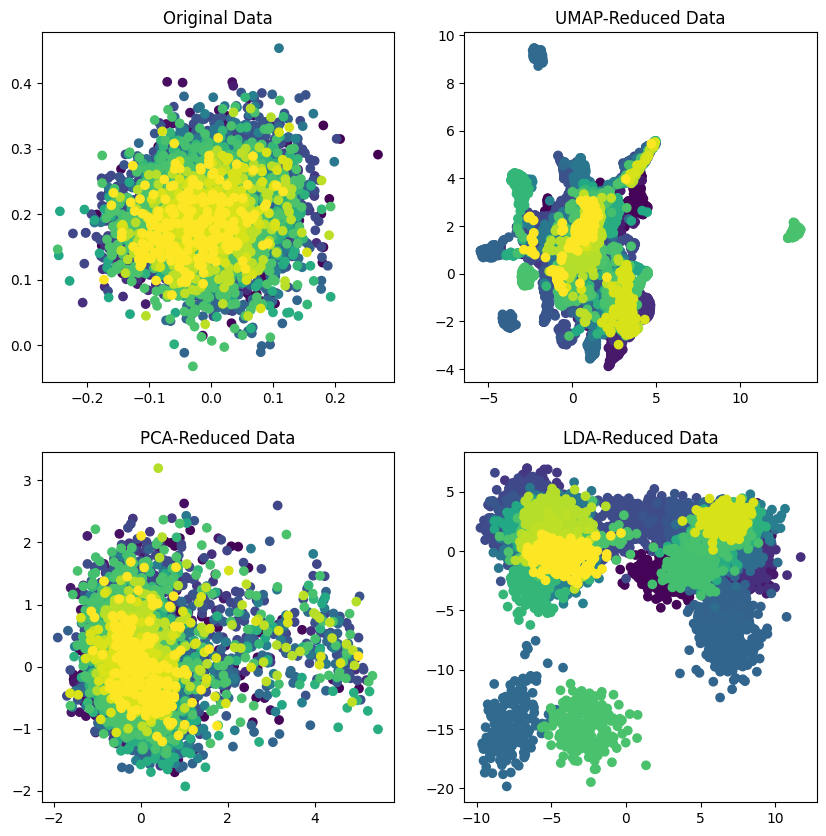

In [162]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title('Original Data')


axs[0, 1].scatter(umap_result[:, 0], umap_result[:, 1], c=y)
axs[0, 1].set_title('UMAP-Reduced Data')


axs[1, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=y)
axs[1, 0].set_title('PCA-Reduced Data')


axs[1, 1].scatter(lda_result[:, 0], lda_result[:, 1], c=y)
axs[1, 1].set_title('LDA-Reduced Data')

plt.show()

As we can observe, LDA is able to better seperate the classes than PCA and umap. The maximum proportion of variance explained by PCA is 20%, it means that the first few principal components are not capturing much of the variation in the data. This suggests that the data may be highly complex or noisy, and that reducing the dimensionality using PCA may not be effective in this case.

In such a scenario, it may be better to explore other dimensionality reduction techniques, such as UMAP,LDA or t-SNE, which are better suited for visualizing high-dimensional data with complex structure. 

As we can observe from these figures, reducing the dimensionality using PCA may not improve the performance of clustering or classification algorithms.

##K-means clusteting

Let us perform kmeans on original and reduced data and plot them.

###2D

In [ ]:
# Perform KMeans clustering on original data
kmeans_orig = KMeans(n_clusters=40, random_state=42)
kmeans_orig.fit(X)
y_pred_orig = kmeans_orig.predict(X)

kmeans_pca = KMeans(n_clusters=40, random_state=42)
kmeans_pca.fit(pca_result)
y_pred_pca = kmeans_pca.predict(pca_result)

# Perform KMeans clustering on UMAP-reduced data
kmeans_umap = KMeans(n_clusters=40, random_state=42)
kmeans_umap.fit(umap_result)
y_pred_umap = kmeans_umap.predict(umap_result)

# Perform KMeans clustering on LDA-reduced data
kmeans_lda = KMeans(n_clusters=40, random_state=42)
kmeans_lda.fit(lda_result)
y_pred_lda = kmeans_lda.predict(lda_result)

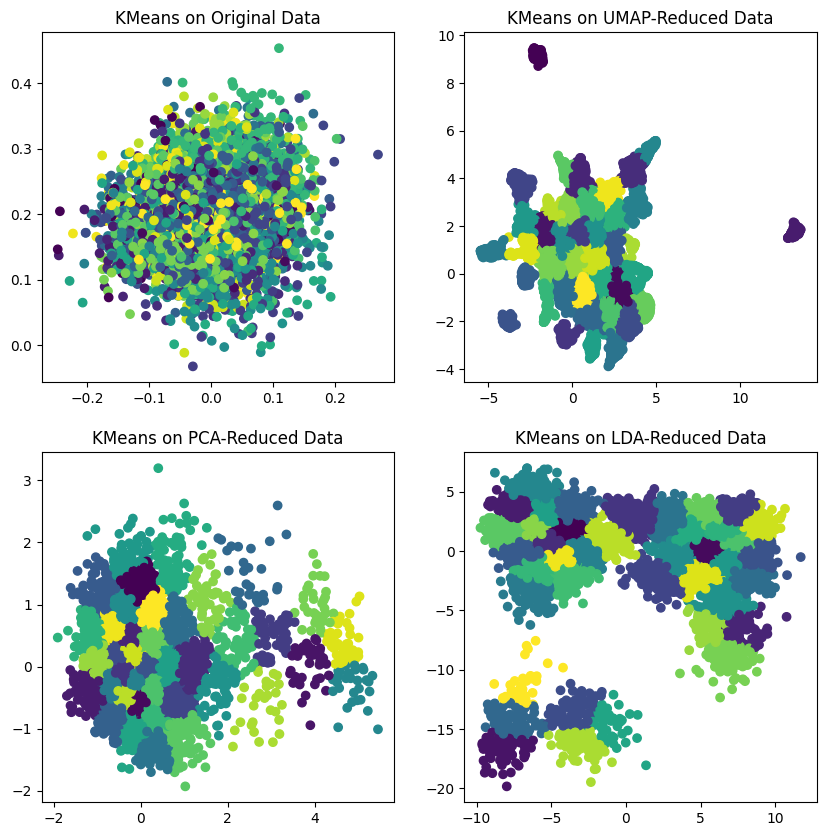

In [164]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred_orig)
axs[0, 0].set_title('KMeans on Original Data')


axs[0, 1].scatter(umap_result[:, 0], umap_result[:, 1], c=y_pred_umap)
axs[0, 1].set_title('KMeans on UMAP-Reduced Data')


axs[1, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_pca)
axs[1, 0].set_title('KMeans on PCA-Reduced Data')


axs[1, 1].scatter(lda_result[:, 0], lda_result[:, 1], c=y_pred_lda)
axs[1, 1].set_title('KMeans on LDA-Reduced Data')

plt.show()

###3D

In [166]:

pca_model = PCA(n_components=3)
pca_result = pca_model.fit_transform(X)


umap_model = umap.UMAP(n_components=3)
umap_result = umap_model.fit_transform(X)

lda_model = LDA(n_components=3)
lda_result = lda_model.fit_transform(X, y)

In [ ]:
# Perform KMeans clustering on original data
kmeans_orig = KMeans(n_clusters=40, random_state=42)
kmeans_orig.fit(X)
y_pred_orig = kmeans_orig.predict(X)

# Perform KMeans clustering on PCA-reduced data
kmeans_pca = KMeans(n_clusters=40, random_state=42)
kmeans_pca.fit(pca_result)
y_pred_pca = kmeans_pca.predict(pca_result)

# Perform KMeans clustering on UMAP-reduced data
kmeans_umap = KMeans(n_clusters=40, random_state=42)
kmeans_umap.fit(umap_result)
y_pred_umap = kmeans_umap.predict(umap_result)

# Perform KMeans clustering on LDA-reduced data
kmeans_lda = KMeans(n_clusters=40, random_state=42)
kmeans_lda.fit(lda_result)
y_pred_lda = kmeans_lda.predict(lda_result)


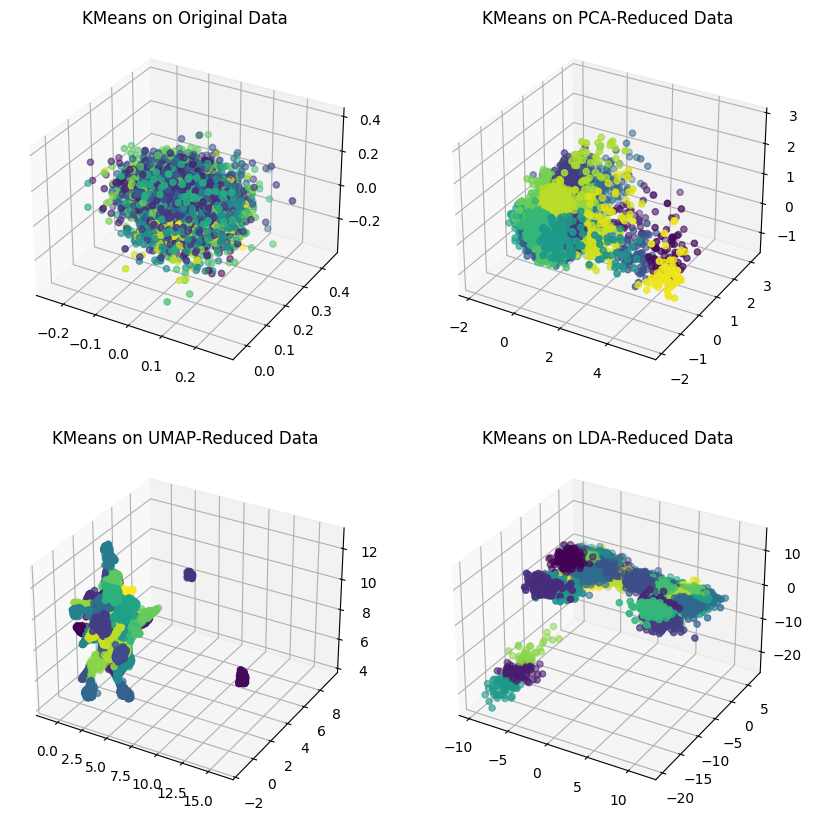

In [169]:

# Visualize original data and KMeans clustering
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred_orig)
ax.set_title('KMeans on Original Data')

# Visualize PCA-reduced data and KMeans clustering
ax = fig.add_subplot(222, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=y_pred_pca)
ax.set_title('KMeans on PCA-Reduced Data')

# Visualize UMAP-reduced data and KMeans clustering
ax = fig.add_subplot(223, projection='3d')
ax.scatter(umap_result[:, 0], umap_result[:, 1], umap_result[:, 2], c=y_pred_umap)
ax.set_title('KMeans on UMAP-Reduced Data')

# Visualize LDA-reduced data and KMeans clustering
ax = fig.add_subplot(224, projection='3d')
ax.scatter(lda_result[:, 0], lda_result[:, 1], lda_result[:, 2], c=y_pred_lda)
ax.set_title('KMeans on LDA-Reduced Data')

plt.show()

##Remarks

**Plot Analysis**:

In these plots, we can observe how the original high-dimensional data is projected into lower-dimensional space using different dimensionality reduction techniques such as PCA, LDA, and UMAP. We can also observe how the clustering results of KMeans algorithm are affected by the different dimensionality reduction techniques.

LDA performed best, then umap and then PCA.

LDA was able to better seperate the clusters.
LDA is a supervised learning method, whereas PCA and UMAP are unsupervised. This means that LDA takes into account the class labels when performing dimensionality reduction, which can help to better separate the classes.

PCA was not able to do such a good job. The main drawback of PCA is that it is highly influenced by outliers present in the data. PCA is a linear method, which means that it may not be able to capture the nonlinear relationships between the features and the classes. UMAP is a nonlinear method, but it still may not be able to capture all of the complex relationships in the data.

The number of features (768) is quite high relative to the number of samples, which can make it difficult for unsupervised methods like PCA and UMAP to perform well. In contrast, LDA may be better able to handle this high-dimensional data because it takes into account the class information.